In [15]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Data Loading**

In [0]:
import pandas as pd
data = pd.read_csv("multi_hot_data_main.csv")

In [0]:
data["len"] = data["para"].str.split().str.len()

In [3]:
data.shape

(25000, 29)

In [4]:
data["len"].max()

6192

In [5]:
data["len"].min()

0

In [0]:
sample = data[(data['len'] >= 10) & (data['len'] <=1000)]

In [5]:
sample.head()

,persons covered treaty eligibility,pe,business profits,shipping air transport,interest,royalty,royaltyfts,fts,independent personal services,dividend,capital gains,other treaty issues,gaar,income not includible in total income,profits gains from business profession,other sources,unexplained income,chapter via deductions,minimum alternate tax,prosecution,interest (interest on income tax refund),carry forward of losses,penalty,dispute resolution,section 9,refund processing section 143(1d),dividend distribution tax,para,len
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,consequently the forex loss was allowed as cla...,29
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,there is no document whatsoever to show that t...,65
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3 the ld cit(a) has erred in law and on facts...,32
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4 af ter hearing the learned representatives ...,63
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,8 section 36 (1)(iii) of the income tax act 1...,202


In [6]:
sample.shape

(24664, 29)

# **Importing Relevant Dependencies**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model, load_model 
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, Conv1D,Dense, Embedding, Input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from sklearn import metrics
from sklearn.model_selection import train_test_split

# **Splitting Data**

In [0]:
train, test = train_test_split(sample,test_size=0.2,random_state=123)

In [9]:
print(train.shape)
print(test.shape)

(19731, 29)
(4933, 29)


In [0]:
features_train = train.iloc[:,-2]
features_test = test.iloc[:,-2]

In [11]:
features_train

3310     6 for the proposition that on a mere differenc...
5553     11 the learned cit (dr) countering the submiss...
9363     4 on query by the bench assessee has filed rec...
1382      18 in substance the contention of the learned...
5528     13 the next gift deed available on pages 50 an...
                               ...                        
15590     32 sec 18 of the indian partnership act runs ...
21899    4 learned counsel for the appellant submits th...
17976     18 on these facts the question posed before t...
15944    5 now we take the appeals filed by the assesse...
20242     13 he pointed out that the ito referred to th...
Name: para, Length: 19731, dtype: object

In [0]:
y_train = train.iloc[:,1:-2].values
y_test = test.iloc[:,1:-2].values

In [14]:
y_train.shape

(19731, 26)

# **Data Preparation**

In [16]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open("drive/My Drive/ content glove glove.42B.300d.txt") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))


Loading word vectors...
Found 1917494 word vectors.


In [0]:
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 300

In [0]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(features_train)
sequences_train = tokenizer.texts_to_sequences(features_train)
sequences_test = tokenizer.texts_to_sequences(features_test)

In [19]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 105026 unique tokens.


In [0]:
length = []

for i in sequences_train:

  length.append(len(i))

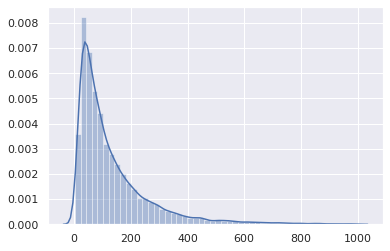

In [21]:
sns.set()
sns.distplot(length)

In [0]:
MAX_SEQUENCE_LENGTH = 100

In [23]:
encoded_train = pad_sequences(sequences_train,maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', encoded_train.shape)
encoded_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', encoded_test.shape)

Shape of data tensor: (19731, 100)
Shape of data tensor: (4933, 100)


# **Model Building**

In [24]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Filling pre-trained embeddings...
(20000, 300)


In [0]:
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)



print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = Conv1D(filters=100,kernel_size=2,padding="valid",activation="relu")(x)
x = Conv1D(filters=100,kernel_size=3,padding="valid",activation="relu")(x)
x = Conv1D(filters=100,kernel_size=4,padding="valid",activation="relu")(x)
x = GlobalMaxPool1D()(x)
output = Dense(26, activation="sigmoid")(x)

model = Model(input_, output)

In [0]:
# Callbacks
model_1 = ModelCheckpoint('model_bilstm_multilabel.h5', save_best_only=True, monitor='val_loss', mode='min')
logdir = "logs/model_bilstm_multilabel/"
tensorboard_callback = TensorBoard(log_dir=logdir)

In [0]:
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy']
)

In [28]:
print('Training model...')
r = model.fit(
  encoded_train,
  y_train,
  batch_size=512,
  epochs=10,
  validation_data=(encoded_test,y_test),callbacks=[tensorboard_callback,model_1]
)

Training model...


Train on 19731 samples, validate on 4933 samples


Epoch 1/10
19731/19731 [==============================] - 18s 905us/step - loss: 0.2331 - acc: 0.9091 - val_loss: 0.1891 - val_acc: 0.9256

Epoch 2/10
19731/19731 [==============================] - 12s 631us/step - loss: 0.1804 - acc: 0.9270 - val_loss: 0.1768 - val_acc: 0.9262
Epoch 3/10
19731/19731 [==============================] - 12s 617us/step - loss: 0.1725 - acc: 0.9281 - val_loss: 0.1733 - val_acc: 0.9276
Epoch 4/10
19731/19731 [==============================] - 12s 633us/step - loss: 0.1673 - acc: 0.9302 - val_loss: 0.1705 - val_acc: 0.9297
Epoch 5/10
19731/19731 [==============================] - 12s 617us/step - loss: 0.1630 - acc: 0.9321 - val_loss: 0.1676 - val_acc: 0.9304
Epoch 6/10
19731/19731 [==============================] - 12s 627us/step - loss: 0.1592 - acc: 0.9330 - val_loss: 0.1642 - val_acc: 0.9316
Epoch 7/10
19731/19731 [==============================] - 12s 628us/step - loss: 0.1507 - acc:

In [0]:
predictions = model.predict(encoded_test,batch_size=512)

# **f1 micro // 0.1 to 0.5**

In [30]:
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_test, (predictions>thresh).astype(int),average="micro")))

F1 score at threshold 0.1 is 0.5011738926279543
F1 score at threshold 0.11 is 0.5111429688518181
F1 score at threshold 0.12 is 0.5202617925328089
F1 score at threshold 0.13 is 0.5278070730506925
F1 score at threshold 0.14 is 0.535778077497904
F1 score at threshold 0.15 is 0.5427599243856333
F1 score at threshold 0.16 is 0.5495608531994982
F1 score at threshold 0.17 is 0.5541416761225483
F1 score at threshold 0.18 is 0.5574498387299459
F1 score at threshold 0.19 is 0.5618758141554494
F1 score at threshold 0.2 is 0.5653129908009871
F1 score at threshold 0.21 is 0.5694006309148264
F1 score at threshold 0.22 is 0.5738214883943528
F1 score at threshold 0.23 is 0.5757650421327551
F1 score at threshold 0.24 is 0.5776696568851046
F1 score at threshold 0.25 is 0.5799198459376464
F1 score at threshold 0.26 is 0.5829118977907904
F1 score at threshold 0.27 is 0.5848379377855123
F1 score at threshold 0.28 is 0.5862488928255092
F1 score at threshold 0.29 is 0.5863019866058867
F1 score at threshold 0

# **Precision // 0.1 to 0.5**

In [31]:
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.precision_score(y_test, (predictions>thresh).astype(int),average="micro")))

F1 score at threshold 0.1 is 0.35727037400696243
F1 score at threshold 0.11 is 0.3708221056114972
F1 score at threshold 0.12 is 0.38451127819548875
F1 score at threshold 0.13 is 0.39704871211720527
F1 score at threshold 0.14 is 0.4106963227897619
F1 score at threshold 0.15 is 0.4244574537283425
F1 score at threshold 0.16 is 0.4389602254932665
F1 score at threshold 0.17 is 0.45167470436678336
F1 score at threshold 0.18 is 0.4642109669317706
F1 score at threshold 0.19 is 0.47957897857831144
F1 score at threshold 0.2 is 0.49419425702181075
F1 score at threshold 0.21 is 0.510693184655072
F1 score at threshold 0.22 is 0.5279147587178584
F1 score at threshold 0.23 is 0.5432397247535801
F1 score at threshold 0.24 is 0.5591640502354788
F1 score at threshold 0.25 is 0.5758734752946041
F1 score at threshold 0.26 is 0.5921479558728099
F1 score at threshold 0.27 is 0.6076392812747203
F1 score at threshold 0.28 is 0.6211143695014663
F1 score at threshold 0.29 is 0.6329283110571081
F1 score at thres

In [32]:
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.recall_score(y_test, (predictions>thresh).astype(int),average="micro")))

F1 score at threshold 0.1 is 0.8391864975364294
F1 score at threshold 0.11 is 0.8223084180731733
F1 score at threshold 0.12 is 0.8041723451095503
F1 score at threshold 0.13 is 0.7869797672712024
F1 score at threshold 0.14 is 0.7704161861830381
F1 score at threshold 0.15 is 0.7524897788028095
F1 score at threshold 0.16 is 0.7346682042142783
F1 score at threshold 0.17 is 0.7167417968340497
F1 score at threshold 0.18 is 0.6975573959534542
F1 score at threshold 0.19 is 0.6782681622811616
F1 score at threshold 0.2 is 0.660341754900933
F1 score at threshold 0.21 is 0.6433588426459796
F1 score at threshold 0.22 is 0.6284725862249712
F1 score at threshold 0.23 is 0.612433169095293
F1 score at threshold 0.24 is 0.5974420798825872
F1 score at threshold 0.25 is 0.5840234825453402
F1 score at threshold 0.26 is 0.5739595345424049
F1 score at threshold 0.27 is 0.5636859209560751
F1 score at threshold 0.28 is 0.5550896320369011
F1 score at threshold 0.29 is 0.5460740119509383
F1 score at threshold 0.